In [136]:
import wandb
import random

from tqdm.auto import tqdm

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [20]:
api = wandb.Api()
wandb.login()

wandb: Currently logged in as: jarjumarvin. Use `wandb login --relogin` to force relogin


True

In [61]:
l_runs = [run for run in api.runs(path="dyck-benchmark/uncategorized") if run.state == 'finished']

In [107]:
runs = []

for run in tqdm(l_runs, desc="Loading and extracting config and history from runs"):
    keys = ["M", "k", "num_heads", "hidden_size", "num_layers", "word_length"]
    config = run.config
    
    if any([key not in config for key in keys]):
        continue

    summary = {k: int(v) for k, v in run.config.items() if k in keys}
    history = run.history()
    
    # drop irrelevant runs
    if summary["num_heads"] != 4:
        continue
    
    if "Test_accuracy" not in history or "Validation_accuracy" not in history:
        continue

    summary["test_acc"] = max(history["Test_accuracy"].dropna())
    summary["val_acc"] = max(history["Validation_accuracy"].dropna())

    runs.append(summary)

runs = pd.DataFrame(runs)
runs.head()

Loading and extracting config and history from runs:   0%|          | 0/182 [00:00<?, ?it/s]

,M,k,num_heads,num_layers,hidden_size,word_length,test_acc,val_acc
0,1,15,4,5,16,1024,0.9935,0.9965
1,1,15,4,5,16,512,0.9955,0.9925
2,1,15,4,5,16,256,0.9925,0.9995
3,1,15,4,3,16,1024,0.9870,0.9915
4,1,15,4,3,16,512,0.9285,0.9890


/Users/marvinjarju/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/marvinjarju/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/marvinjarju/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/marvinjarju/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/marvinjarju/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/marvinjarju/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index

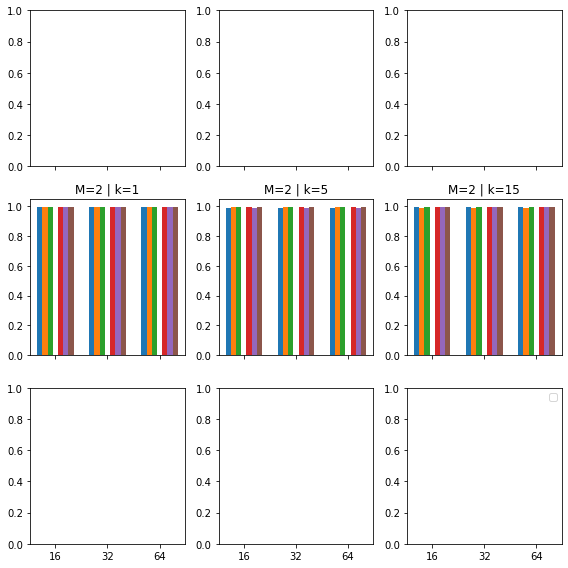

In [166]:
from itertools import product

M_k_combos = list(product([1, 2, 5], [1, 5, 15]))

fig, axs = plt.subplots(3, 3, sharex=True, figsize=(8,8))

metric = "test_acc"

for combo, ax in zip(M_k_combos, axs.flat):
    M, k = combo
    if M != 2:
        continue

    df = runs.where((runs["M"].astype(int) == M) & (runs["k"].astype(int) == k)).dropna()
    df = df.sort_values([col for col in df.columns])

    # want 6 values per hidden size: namely 3 for every num_layers in [3, 5]

    # do num_layers == 3
    df_3 = df[df["num_layers"] == 3.0]
    vals_3_256 = df_3[df["word_length"] == 256.0][metric].tolist()[0]
    vals_3_512 = df_3[df["word_length"] == 512.0][metric].tolist()[0]
    vals_3_1024 = df_3[df["word_length"] == 1024.0][metric].tolist()[0]
    
    # do num_layers = 5
    df_5 = df[df["num_layers"] == 5.0]
    vals_5_256 = df_5[df["word_length"] == 256.0][metric].tolist()[0]
    vals_5_512 = df_5[df["word_length"] == 512.0][metric].tolist()[0]
    vals_5_1024 = df_5[df["word_length"] == 1024.0][metric].tolist()[0]
    
    
    x = ['16', '32', '64']
    
    X_axis = np.arange(len(x))
    ax.bar(X_axis - 0.3, vals_3_256, 0.1, label='3 Layers', color="blue")
    ax.bar(X_axis - 0.2, vals_3_512, 0.1, label='3 Layers', color="oragne")
    ax.bar(X_axis - 0.1, vals_3_1024, 0.1, label='3 Layers')

    ax.bar(X_axis + 0.1, vals_5_256, 0.1, label='5 Layers')
    ax.bar(X_axis + 0.2, vals_5_512, 0.1, label='5 Layers')
    ax.bar(X_axis + 0.3, vals_5_1024, 0.1, label='5 Layers')
    
    ax.set_title(f"M={M} | k={k}")
    # y256 = vals_3_256[metric].tolist()
    # y512 = vals_3_512[metric].tolist()
    # y512 = vals_3_512[metric].tolist()
    
plt.xticks([0, 1, 2], ["16", "32", "64"])
plt.tight_layout()
plt.legend()
plt.show()

Plot Dimensions: 46 4
